In [2]:
## Graphics plots
library(FactoMineR)
library(ggplot2)

## Differential analysis
library(edgeR)
library(limma)

## General data manipulation
library(tidyr)
library(dplyr)


library(DESeq2)
library(stringr)
library(tximport)

library(PoiClaClu)
library(RColorBrewer)
library(pheatmap)
library(umap)

# Load data

In [3]:
txi <- readRDS("txi.rds")
dim(txi$counts)

[1] 62710    15

In [4]:
# Write the counts to an object
data <- txi$counts %>% 
  round() %>% 
  data.frame()

## Design

In [5]:
### experimental design
condition <- as.factor(c(rep(c("prolif","diff"),7),"diff"))
population <- as.factor(c(rep(c("BT1","BT2","BT54","BT88","LGG275","LGG336","LGG349"),each=2)))
expdes <- data.frame(condition)
#expdes <- data.frame(condition, population)
rownames(expdes) <- colnames(txi$counts)

## put prolif as the reference level
expdes$condition = relevel( expdes$condition, "prolif")
expdes$condition
#expdes$population

(expdes)
dim(expdes)

[1] prolif diff   prolif diff   prolif diff   prolif diff   prolif diff  
[11] prolif diff   prolif diff   diff  
Levels: prolif diff

,condition
,<fct>
BT1_GF,prolif
BT1_noGF,diff
BT2_GF,prolif
BT2_noGF,diff
BT54_GF,prolif
BT54_noGF,diff
BT88_GF,prolif
BT88_noGF,diff
LGG275_GF,prolif


[1] 15  1

## object deseq2

In [6]:
dds <- DESeqDataSetFromTximport(txi, expdes, ~ condition)
dds <- dds[, which(! rownames(colData(dds)) == "LGG85_noGF")]
dds

using just counts from tximport



class: DESeqDataSet 
dim: 62710 14 
metadata(1): version
assays(1): counts
rownames(62710): ENSG00000000003 ENSG00000000005 ... ENSG00000291316
  ENSG00000291317
rowData names(0):
colnames(14): BT1_GF BT1_noGF ... LGG349_GF LGG349_noGF
colData names(1): condition

In [7]:
colData(dds)$population <- population
colData(dds)$condition <- condition[1:14]
design(dds) <- ~ condition + population

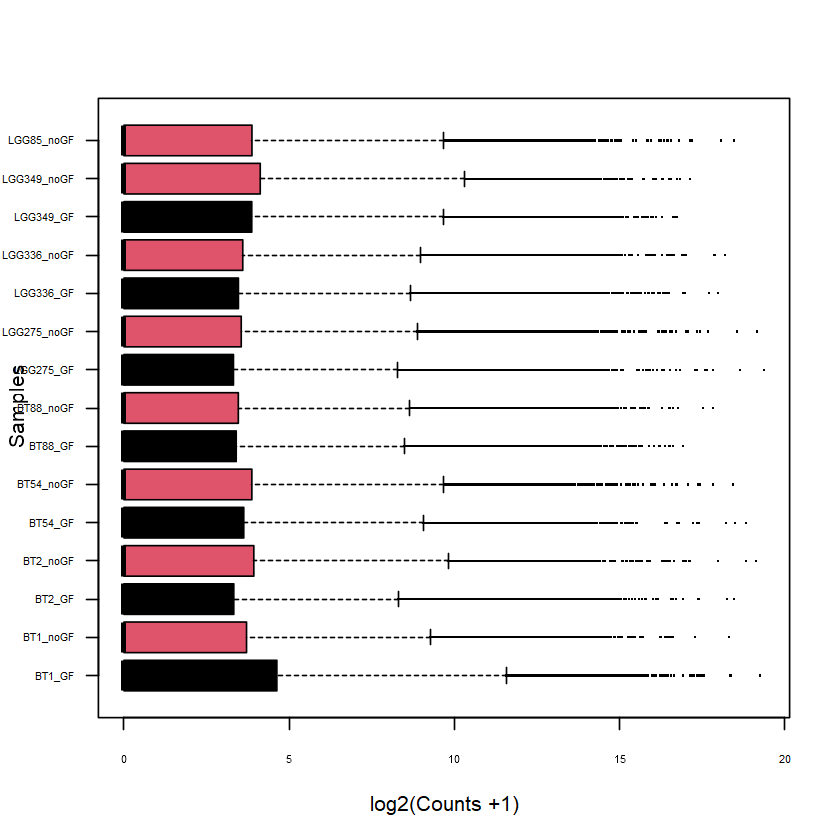

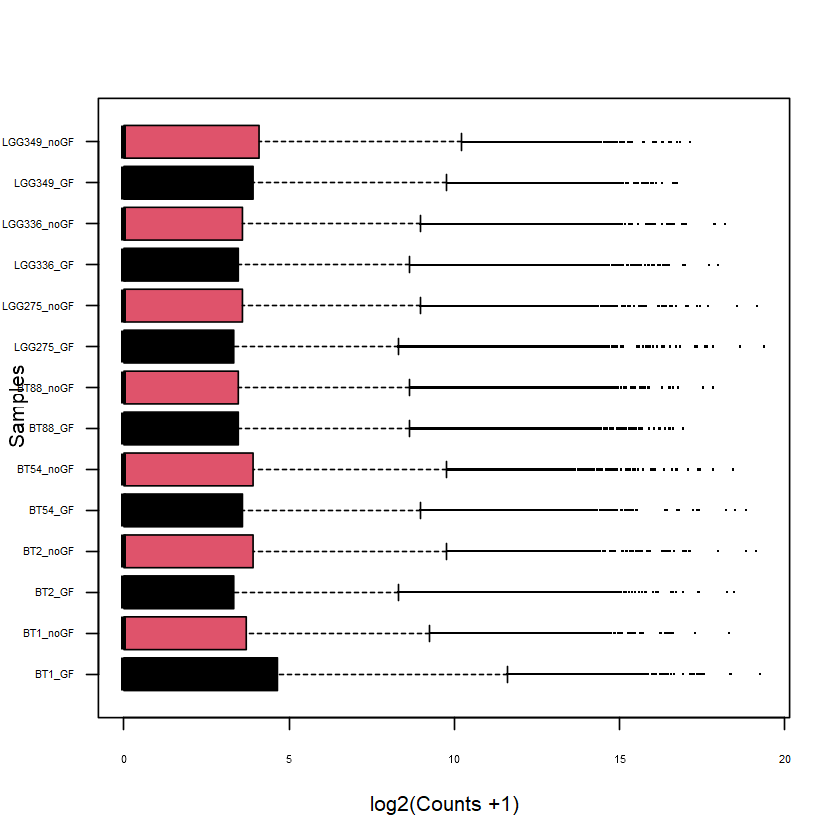

In [8]:
## Boxplots of gene count distributions per sample  (non-normalized log2(counts) per sample.)
count.table <- txi$counts
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")

count.table <- counts(dds)
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")   

## Pre filtering

In [9]:
## filter out genes with 0 counts
nrow(dds)
keep <- rowSums(counts(dds)) > 3
dds <- dds[keep,]
nrow(dds)

[1] 62710

[1] 28257

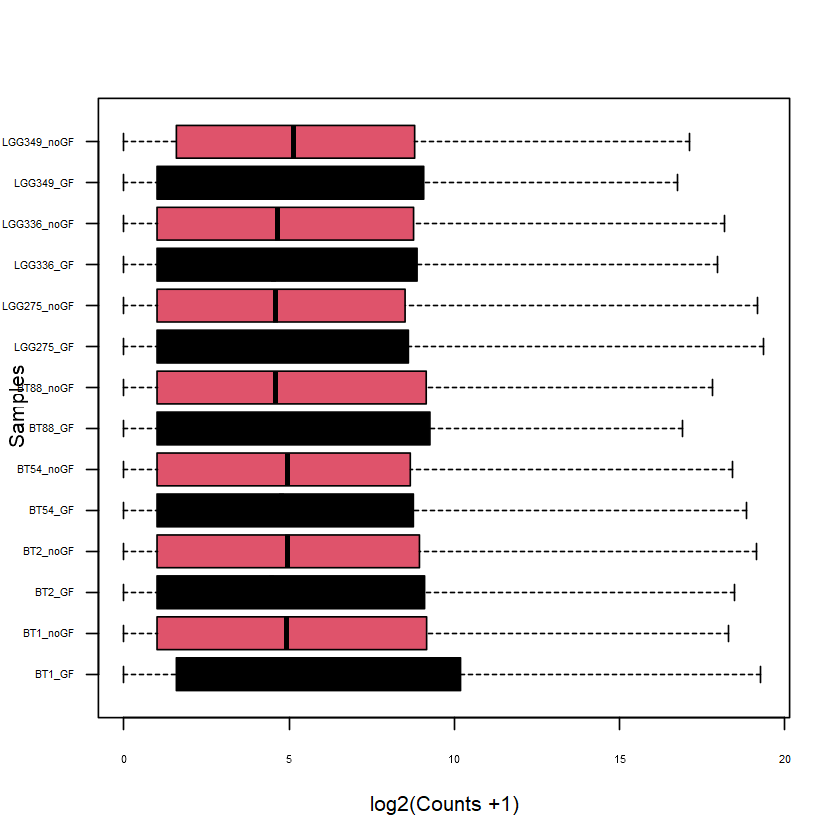

In [10]:
## Boxplots of gene count distributions per sample  (non-normalized log2(counts) per sample.)
count.table <- counts(dds)
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")

# Exploratory analysis

In [26]:
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
## /!\ DESeq2 doesn't accept normalized counts.

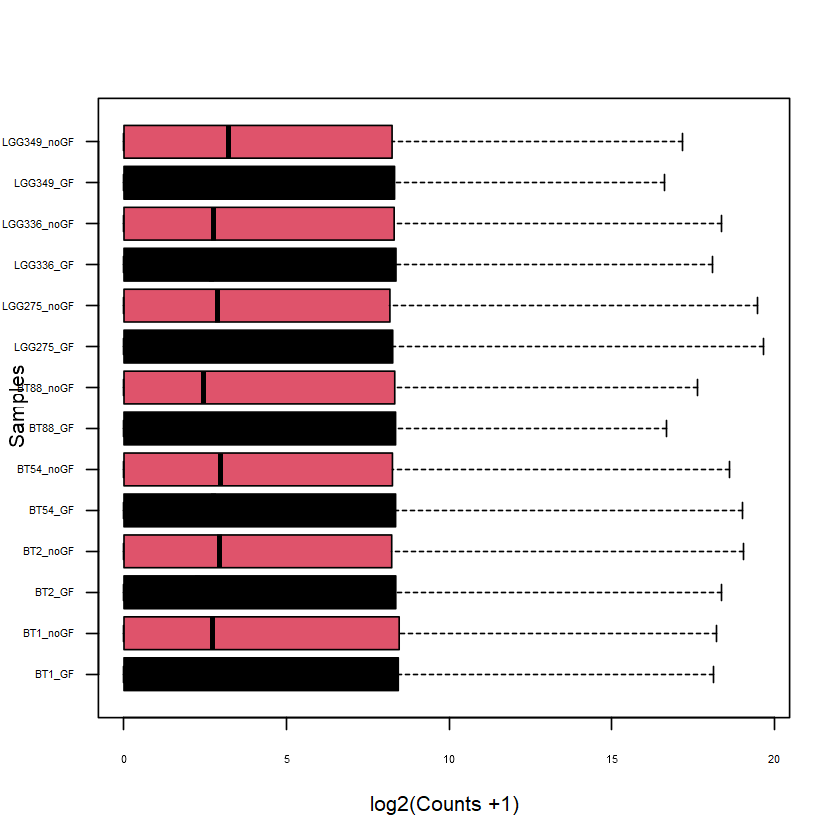

In [53]:
## Boxplots of gene count distributions per sample  (normalized log2(counts) per sample.)
count.table <- normalized_counts
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")

In [27]:
#rld <- rlog(dds, blind = TRUE) # using regularized log transform (rlog), to avoid any bias from the abundance of low-count genes; 
                               #blind = TRUE : does not take our sample group into account (unbiased manner)
vsd <- vst(dds, blind = TRUE)  # if more than 20 samples, might be better to use this function, similar to rlog

In [28]:
### Extract the vst matrix from the object
vsd_mat <- assay(vsd)

## PCA

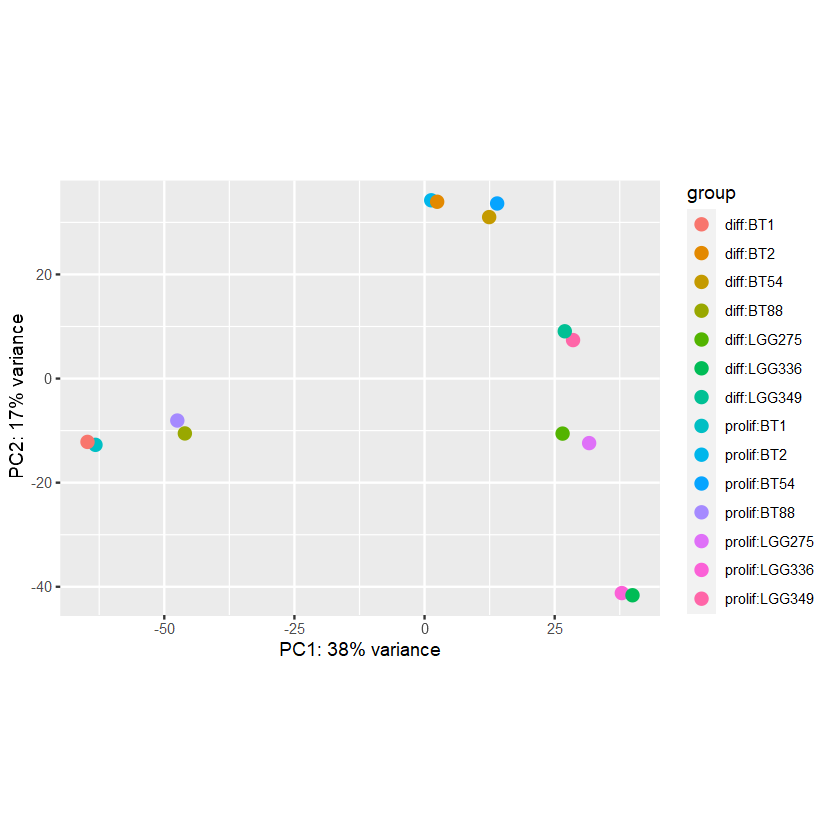

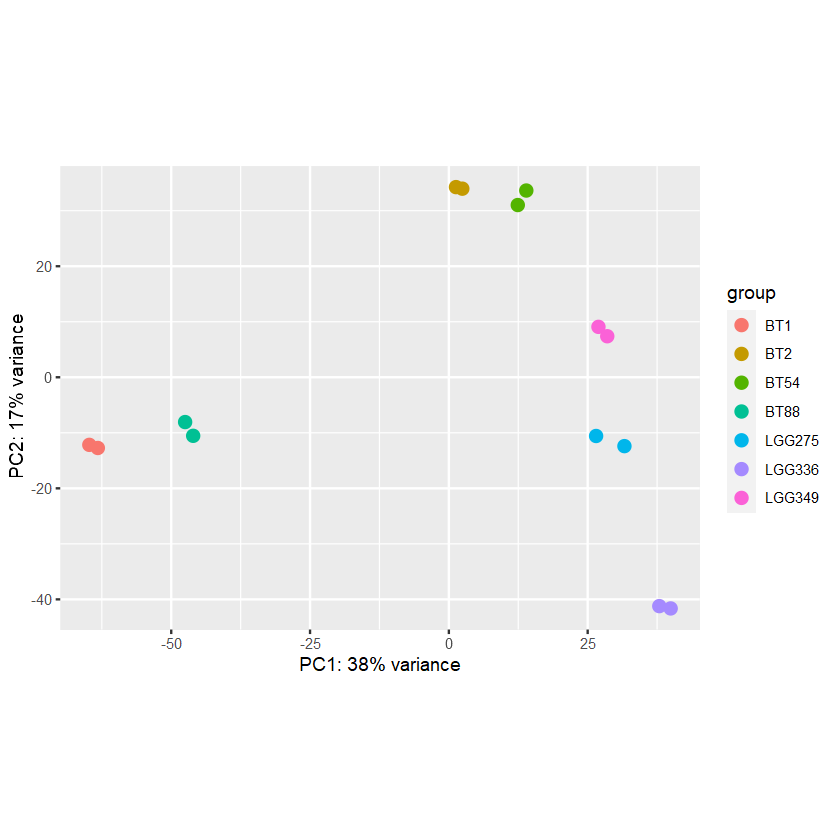

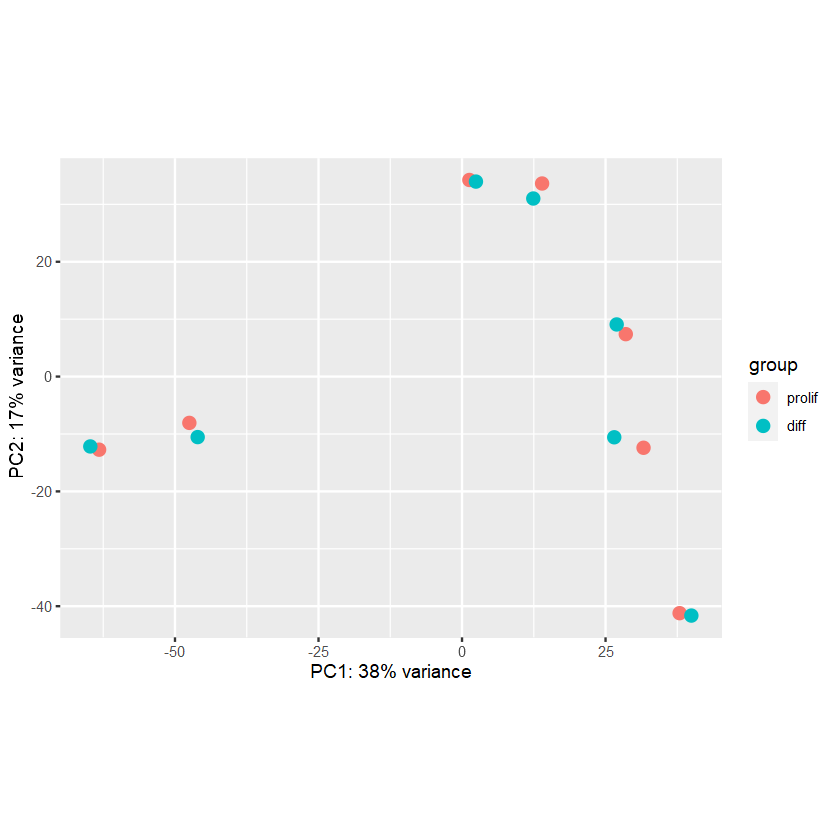

In [62]:
plotPCA(vsd, intgroup = c("condition","population"))
plotPCA(vsd, intgroup = c("population"))
plotPCA(vsd, intgroup = c("condition"))

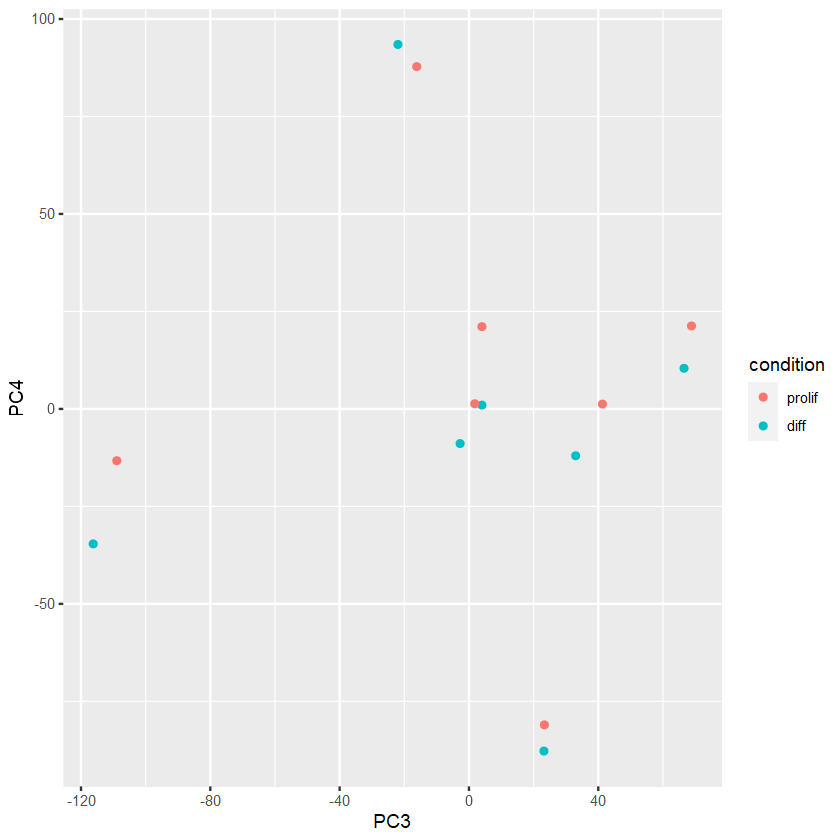

In [64]:
pca <- prcomp(t(vsd_mat))

 # Create data frame with metadata and PC3 and PC4 values for input to ggplot
 df <- cbind(expdes[1:14,], pca$x)
 ggplot(df) + geom_point(aes(x=PC3, y=PC4, color = condition))

## Heatmap

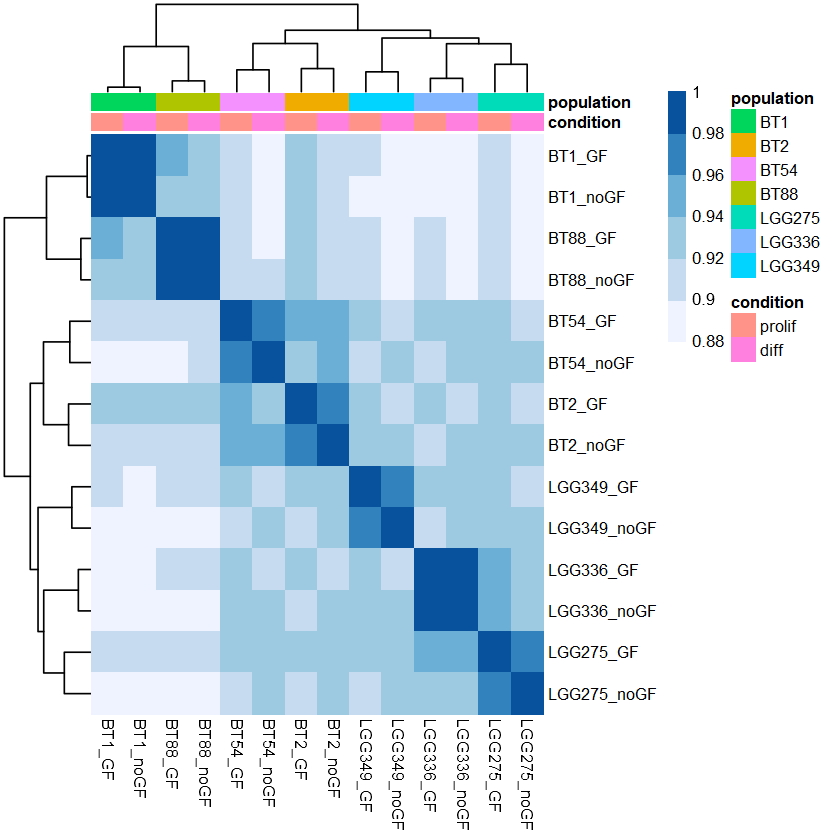

In [65]:
### Compute pairwise correlation values
vsd_mat <- cor(vsd_mat) 
heat.colors <- RColorBrewer::brewer.pal(6, "Blues")
pheatmap(vsd_mat, annotation = expdes, color = heat.colors, border_color=NA, fontsize = 10, 
			fontsize_row = 10, height=20)

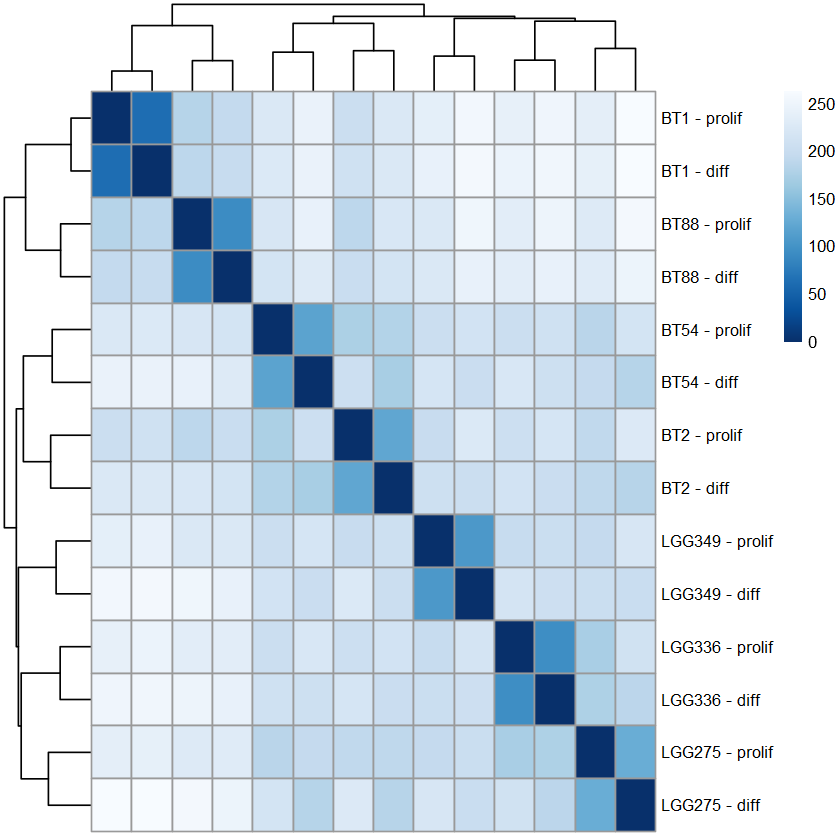

In [66]:
## dist : calculate the Euclidean distance between samples. To ensure we have a roughly equal contribution from all genes, we use it on the VST data

sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( vsd$population, vsd$condition, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

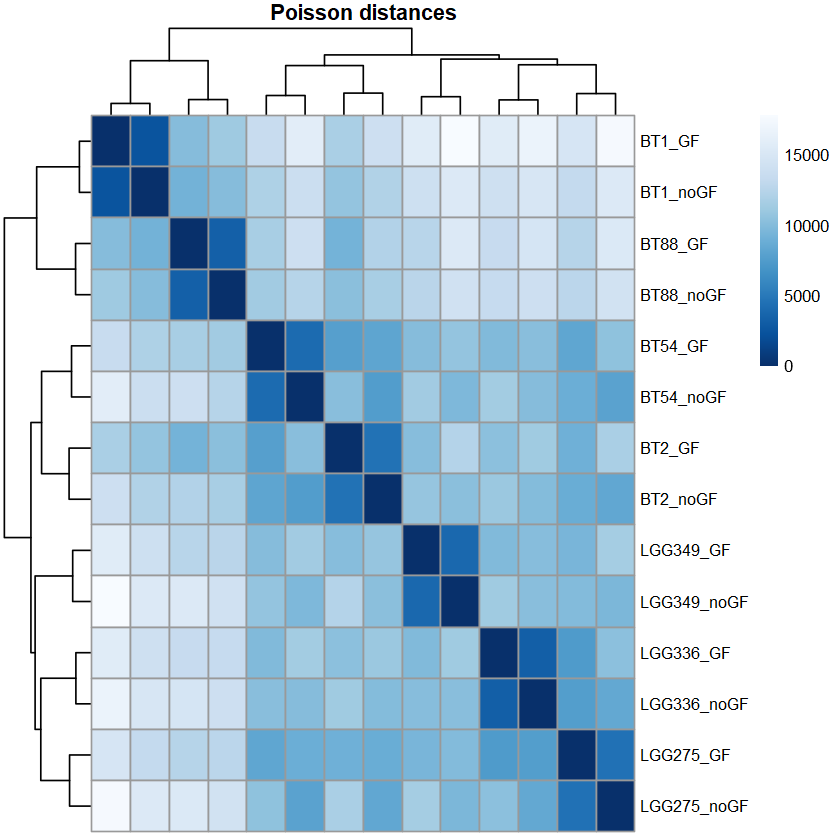

In [67]:
# Heatmap, Poisson
poisd <- PoissonDistance(t(counts(dds))) ## take raw counts
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- colnames(counts(dds))
colnames(samplePoisDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors,
         main = "Poisson distances")


# Analyse diff

### population

In [38]:
design(dds) <- ~ population
dds <- DESeq(dds) 

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 34533 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5185, 15%
LFC < 0 (down)     : 4567, 13%
outliers [1]       : 0, 0%
low counts [2]     : 13456, 39%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



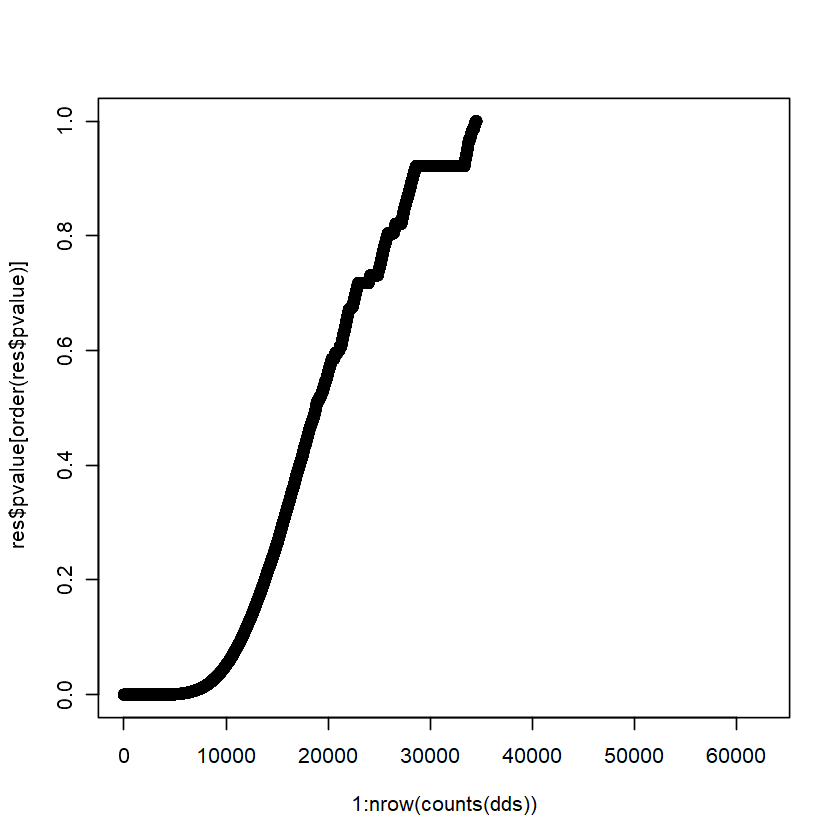

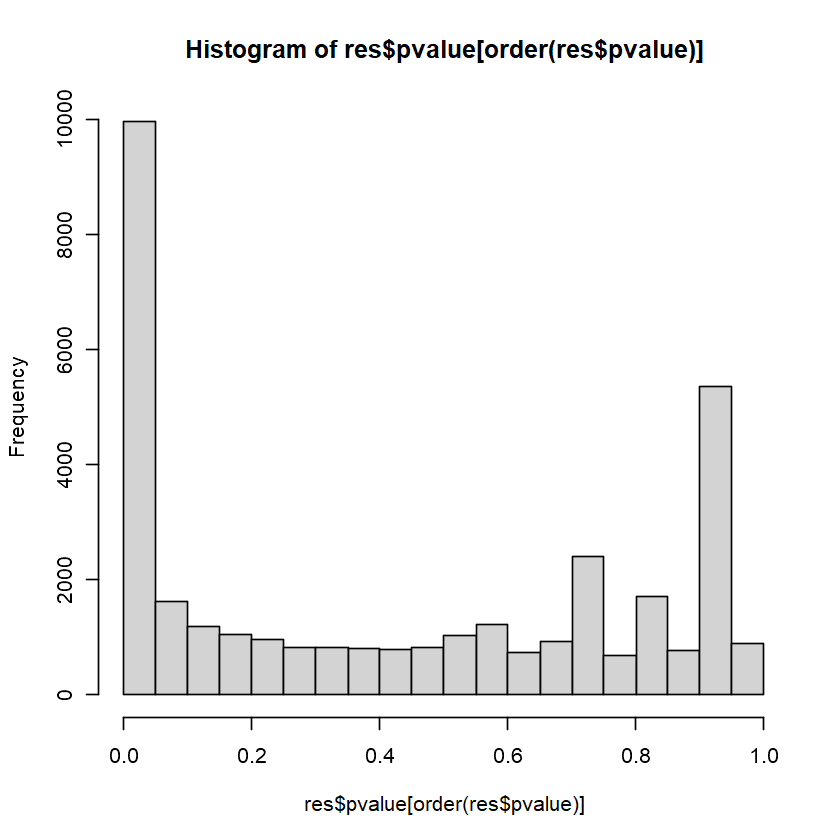

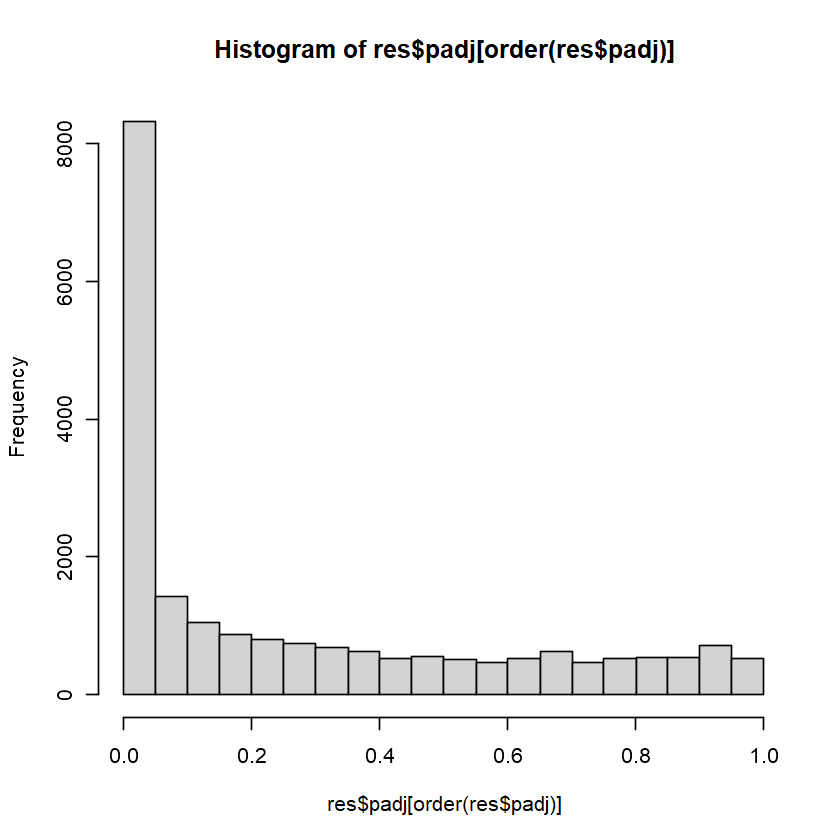

In [39]:
res =  results(dds)
summary(res)
res$pvalue <- res$pvalue[order(res$pvalue)]

plot(1:nrow(counts(dds)), res$pvalue[order(res$pvalue)])
# on ordonne les pvalues par ordre croissant et on affiche un plot des ces pvalues

hist(res$pvalue[order(res$pvalue)])
hist(res$padj[order(res$padj)])

### population + condition

In [11]:
design(dds) <- ~ population + condition
dds <- DESeq(dds) 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 28257 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2882, 10%
LFC < 0 (down)     : 3114, 11%
outliers [1]       : 0, 0%
low counts [2]     : 9313, 33%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



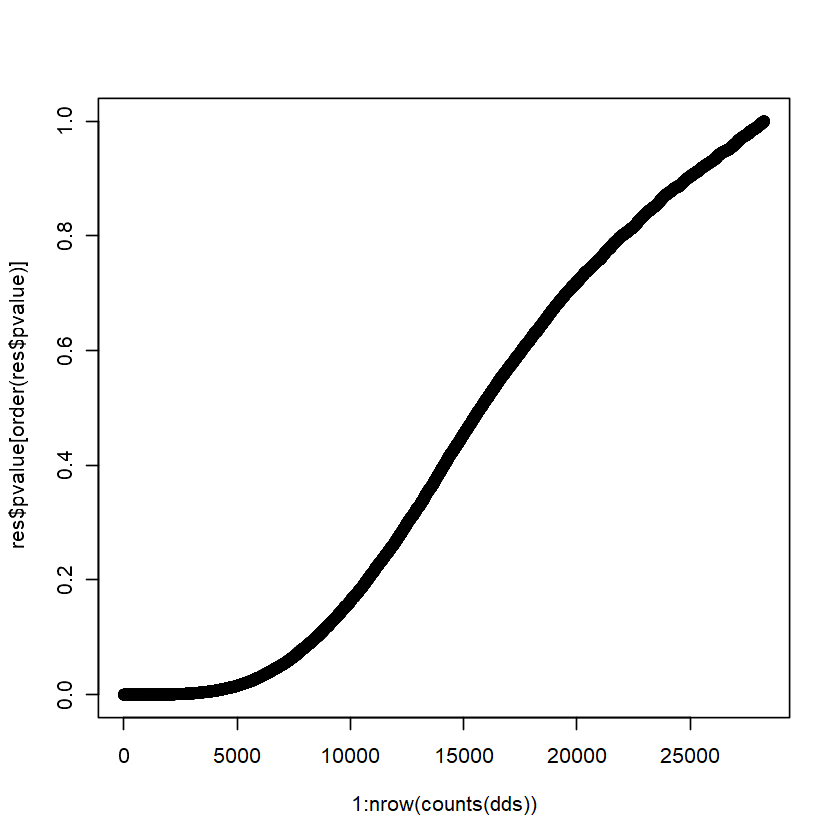

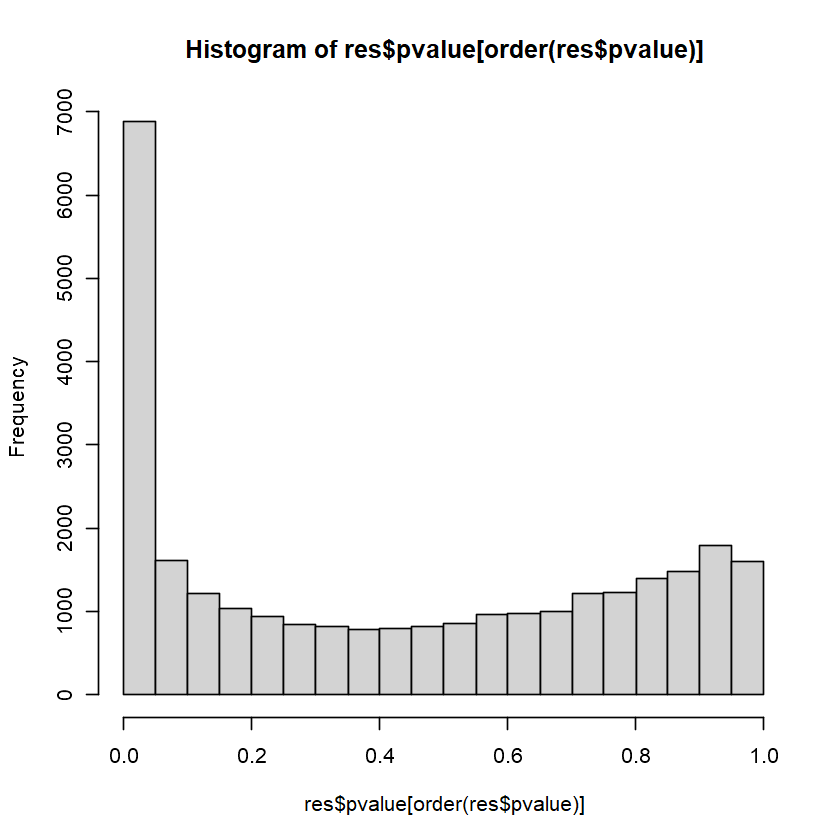

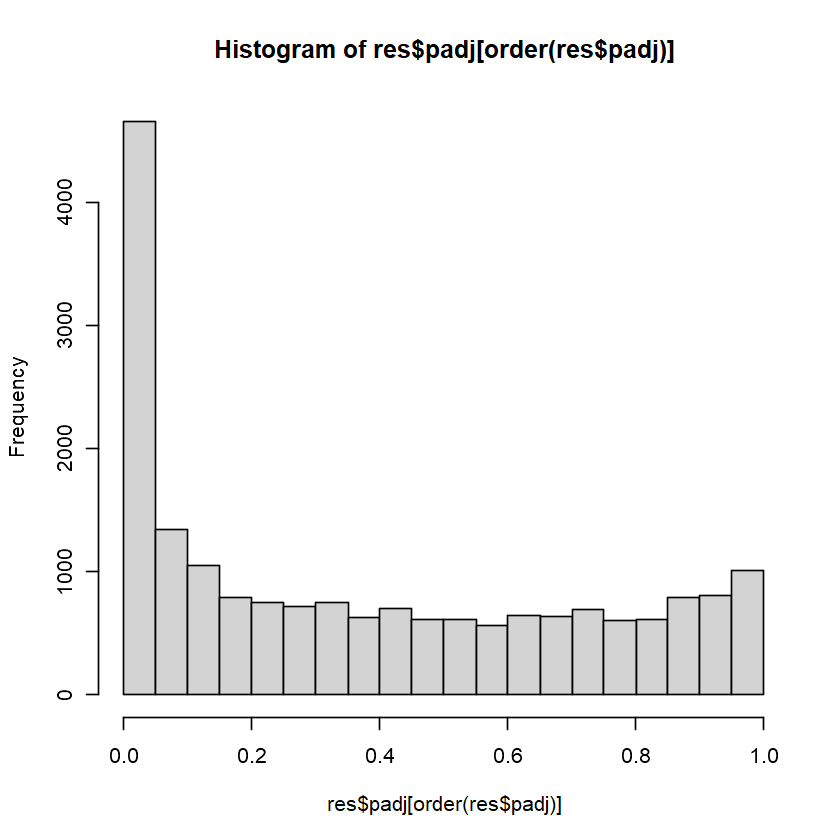

In [12]:
res =  results(dds)
summary(res)
res$pvalue <- res$pvalue[order(res$pvalue)]

plot(1:nrow(counts(dds)), res$pvalue[order(res$pvalue)])
# on ordonne les pvalues par ordre croissant et on affiche un plot des ces pvalues

hist(res$pvalue[order(res$pvalue)])
hist(res$padj[order(res$padj)])

### plots cook

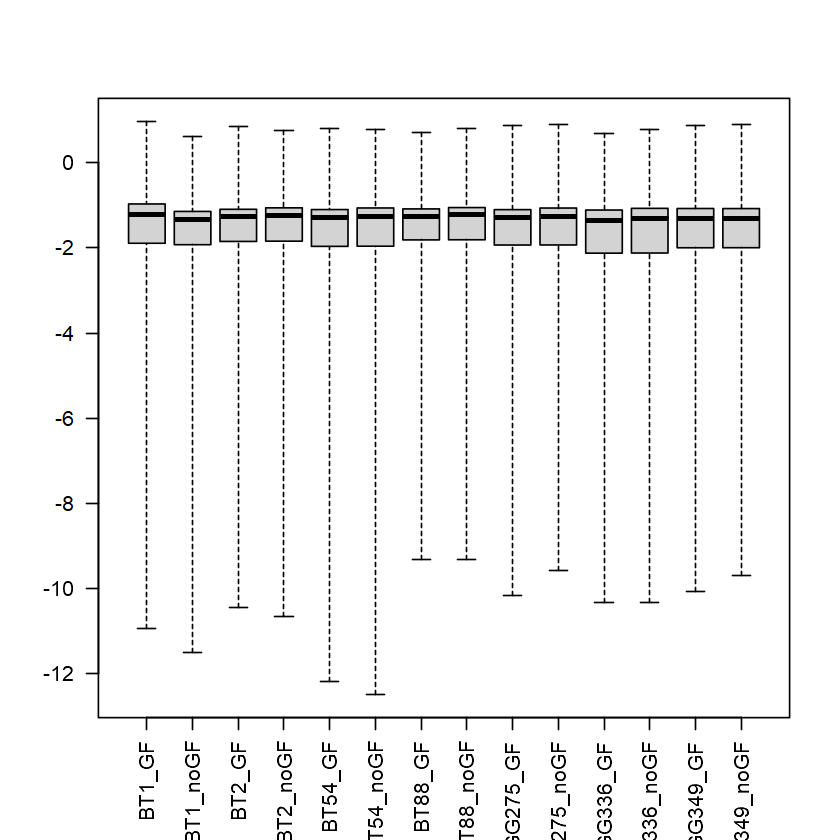

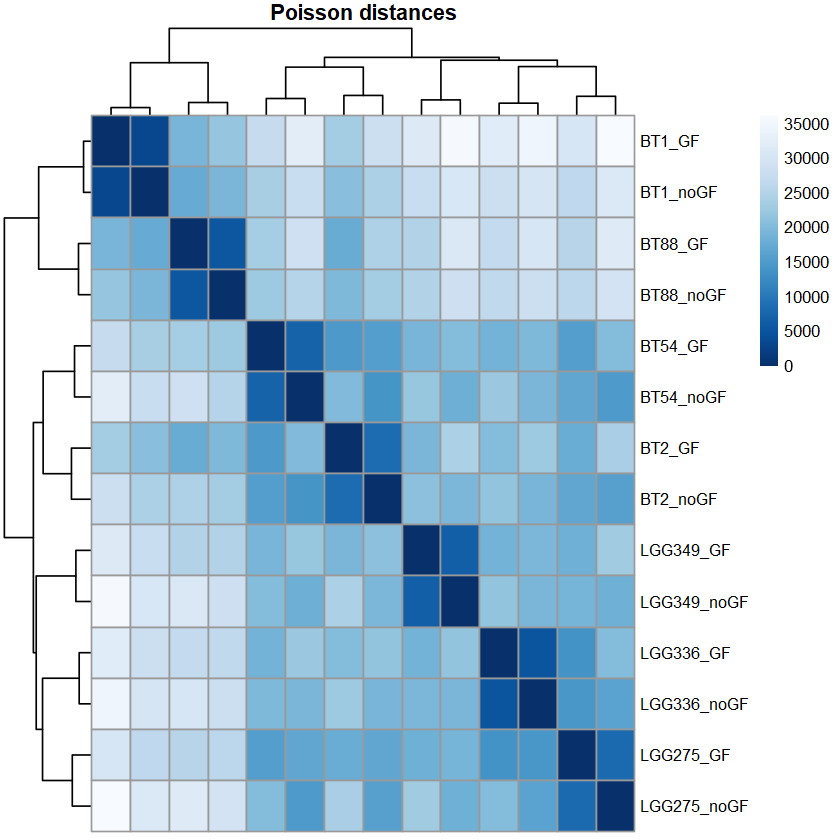

In [33]:
#-----Boxplot of Cooks distances 
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)

# Heatmap, Poisson
poisd <- PoissonDistance(t(counts(dds)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- colnames(counts(dds))
colnames(samplePoisDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors,
         main = "Poisson distances")


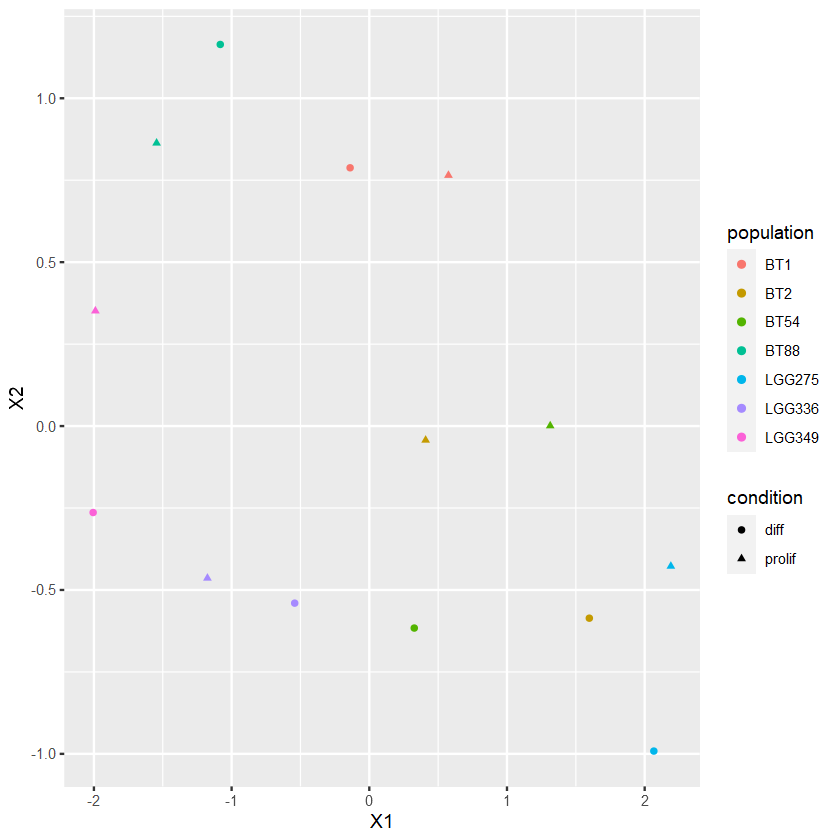

In [60]:
normalized_counts<- t(assay(dds, nonrmalized = TRUE))
umap_results <- umap::umap(normalized_counts, n_neighbors = 4)
umap_plot_df <- data.frame(umap_results$layout)
umap_plot_df$population <- population
umap_plot_df$condition <- condition[1:14]
ggplot(
  umap_plot_df,
  aes(x = X1,y = X2, col=population, shape=condition)) +
  geom_point()

In [50]:
umap_plot_df <- data.frame(umap_results$layout)
head(umap_plot_df)

,X1,X2
,<dbl>,<dbl>
BT1_GF,-0.1827854,0.9590310
BT1_noGF,-0.6462608,0.5388153
BT2_GF,0.4199363,0.3487454
BT2_noGF,1.6144165,0.2389024
BT54_GF,1.2738807,0.7031125
BT54_noGF,0.7110985,1.2957876


# Results

In [14]:
resultsNames(dds)

[1] "Intercept"                "population_BT2_vs_BT1"   
[3] "population_BT54_vs_BT1"   "population_BT88_vs_BT1"  
[5] "population_LGG275_vs_BT1" "population_LGG336_vs_BT1"
[7] "population_LGG349_vs_BT1" "condition_prolif_vs_diff"

In [15]:
resLFC <- lfcShrink(dds, coef="condition_prolif_vs_diff", type="apeglm")
resLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition prolif vs diff 
Wald test p-value: condition prolif vs diff 
DataFrame with 28257 rows and 5 columns
                   baseMean log2FoldChange     lfcSE      pvalue        padj
                  <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000003 1040.694756    -0.05438388  0.146655 6.73546e-01 8.06724e-01
ENSG00000000005    0.536416    -0.00872044  0.314531 7.26226e-01          NA
ENSG00000000419  578.502323     0.26485101  0.114073 1.25615e-02 5.07188e-02
ENSG00000000457  223.837024    -0.12463885  0.151341 3.47106e-01 5.32134e-01
ENSG00000000460  300.334079     1.12990657  0.282646 2.54005e-06 9.07087e-05
...                     ...            ...       ...         ...         ...
ENSG00000291309     2.35802    -0.07566192  0.319023 0.295122308          NA
ENSG00000291313    27.25605     0.02974837  0.311985 0.440056671  0.62059358
ENSG00000291314     1.39701    -0.00685251  0.314977 0.803940896          NA
ENSG00000291316   

In [16]:
resOrdered <- res[order(res$pvalue),]
summary(res)


out of 28257 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2882, 10%
LFC < 0 (down)     : 3114, 11%
outliers [1]       : 0, 0%
low counts [2]     : 9313, 33%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [17]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 5996

In [18]:
res05 <- results(dds, alpha=0.05)
summary(res05)


out of 28257 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2340, 8.3%
LFC < 0 (down)     : 2388, 8.5%
outliers [1]       : 0, 0%
low counts [2]     : 10409, 37%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [19]:
sum(res05$padj < 0.05, na.rm=TRUE)


[1] 4728

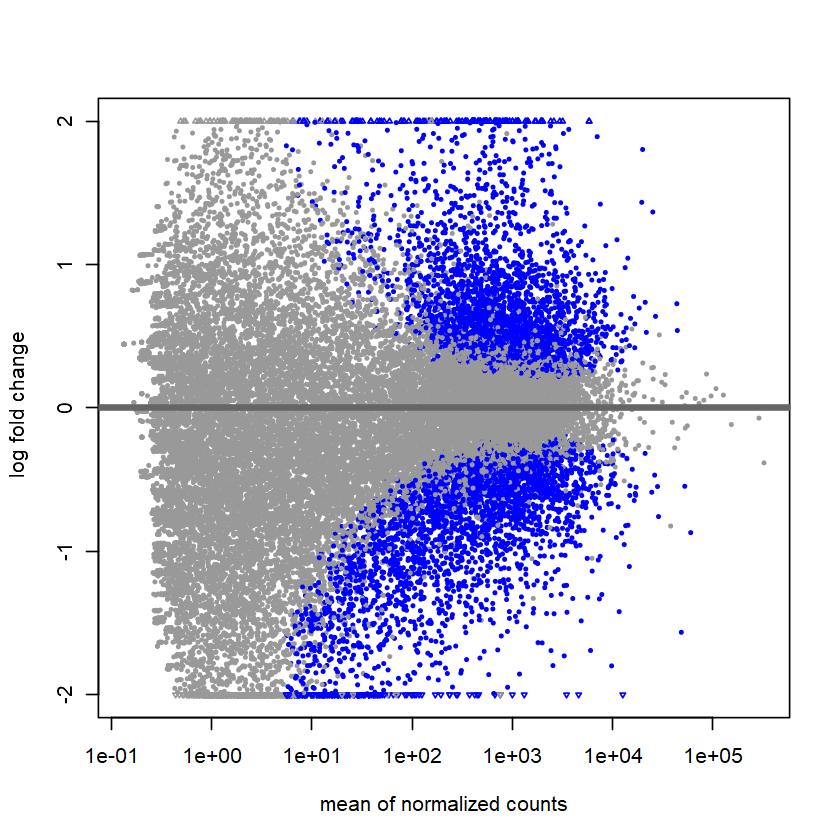

In [13]:
plotMA(res, ylim=c(-2,2))

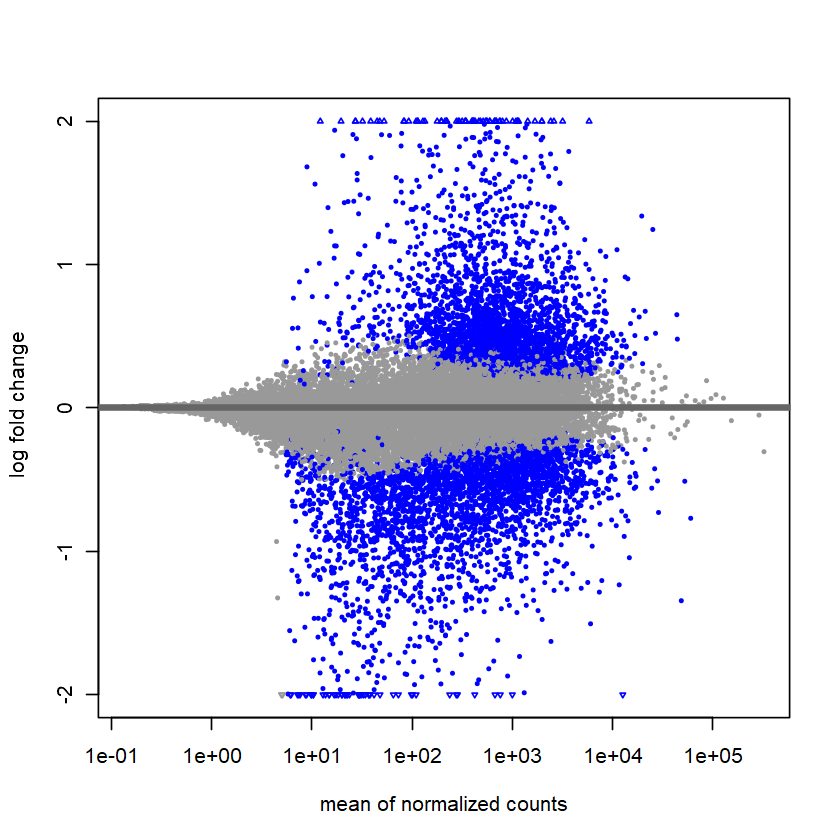

In [20]:
plotMA(resLFC, ylim=c(-2,2))


In [21]:
idx <- identify(res$baseMean, res$log2FoldChange)
rownames(res)[idx]

ERROR: Error in identify.default(res$baseMean, res$log2FoldChange): plot.new has not been called yet


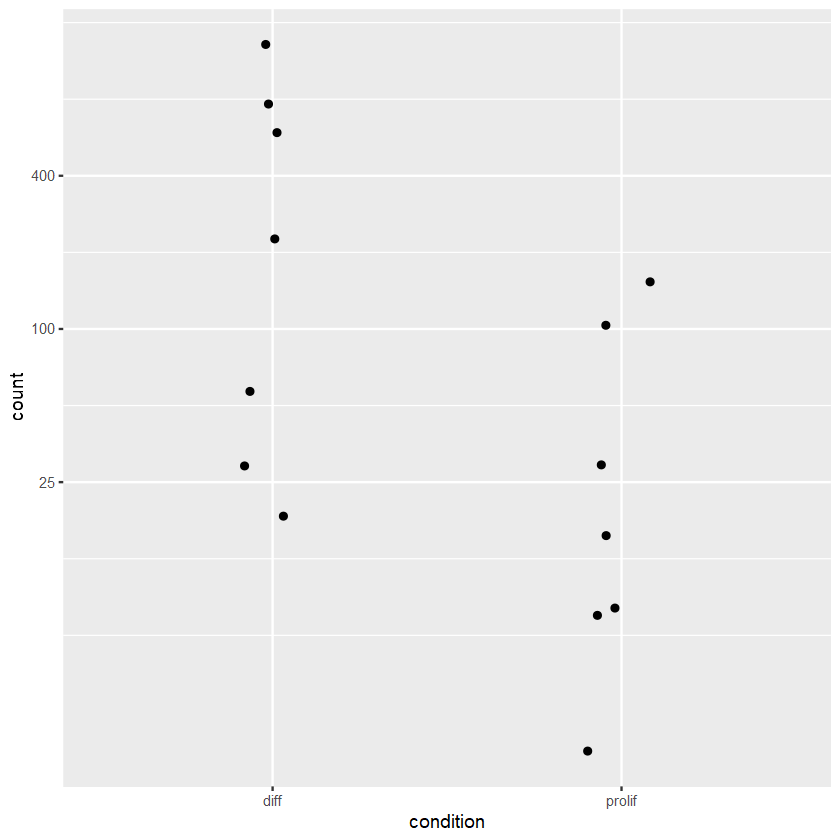

In [24]:
d <- plotCounts(dds, gene=which.min(res$padj), intgroup="condition", 
                returnData=TRUE)
library("ggplot2")
ggplot(d, aes(x=condition, y=count)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10(breaks=c(25,100,400))


In [26]:
vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)
head(assay(vsd), 3)

,BT1_GF,BT1_noGF,BT2_GF,BT2_noGF,BT54_GF,BT54_noGF,BT88_GF,BT88_noGF,LGG275_GF,LGG275_noGF,LGG336_GF,LGG336_noGF,LGG349_GF,LGG349_noGF
ENSG00000000003,9.270771,9.274138,10.339204,10.848073,10.020174,10.378958,9.567328,9.178933,10.536241,10.960500,10.480743,10.404835,9.596545,9.254501
ENSG00000000005,5.620785,5.407206,5.621422,5.623390,5.407206,5.741450,5.407206,5.407206,5.407206,5.655321,5.407206,5.643398,5.407206,5.407206
ENSG00000000419,9.297844,9.260861,9.427720,9.148758,9.820158,9.267236,9.898821,9.519753,9.250242,8.948138,9.389831,9.312995,9.224166,9.055153


In [29]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)
df <- as.data.frame(colData(dds)[,c("condition","population")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

ERROR: Error in h(simpleError(msg, call)): erreur d'ï¿½valuation de l'argument 'x' lors de la sï¿½lection d'une mï¿½thode pour la fonction 'assay' : objet 'ntd' introuvable


In [31]:
colData(dds)

DataFrame with 14 rows and 3 columns
            condition population sizeFactor
             <factor>   <factor>  <numeric>
BT1_GF         prolif       BT1    2.146533
BT1_noGF       diff         BT1    1.062951
BT2_GF         prolif       BT2    1.066886
BT2_noGF       diff         BT2    1.047515
BT54_GF        prolif       BT54   0.871993
...               ...        ...        ...
LGG275_noGF    diff       LGG275   0.794774
LGG336_GF      prolif     LGG336   0.910549
LGG336_noGF    diff       LGG336   0.877242
LGG349_GF      prolif     LGG349   1.088709
LGG349_noGF    diff       LGG349   0.956787